# Trabalho #1 - RNA convolucional

Nesse trabalho você vai desenvolver uma rede neural convolucional deep-learning usando a plataforma TensorFlow-Keras, para realizar uma tarefa de classificação de múltiplas classes, que consiste na identificação de sinais de mão a partir de imagens.

## Coloque os nomes e RAs dos alunos que fizeram esse trabalho

Nome e número dos alunos da equipe:

Aluno 1: Igor Amaral Correa 20.83992-8

Aluno 2: 

Em primeiro lugar é necessário importar alguns pacotes do Python que serão usados nesse trabalho:
- [numpy](www.numpy.org) pacote de cálculo científico com Python
- [matplotlib](http://matplotlib.org) biblioteca para gerar gráficos em Python
- utils.py função para ler banco de dados 

In [0]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

## 1 - Visão geral do problema ##

**Definição do problema:** 

O objetivo desse problema é desenvolver uma RNA que recebe como entrada uma imagem de sinais de mão, avalia a probabilidade dos dedos da mão mostrarem um número de 0 a 5 e determina qual o número mais provável entre os seis possíveis.

O banco de dados usado nesse trabalho é SIGNS, que consiste de imagens de sinais de mão desenvolvido por Andre Ng. Esse banco de dados pode ser obtido no link: https://github.com/cs230-stanford/cs230-code-examples/tree/master/tensorflow/vision

O banco de dados possui 1080 exemplos de treinamento e 120 exemplos de teste. Cada exemplo consiste de uma imagem colorida associada a um rótulo de 6 classes. A Figura abaixo mostra alguns exemplos dessas imagens.

<img src="SIGNS.png" style="width:800px;height:300px;">

## 2 - Dados de treinamento

Os dados que iremos utilizar nesse trabalho estão nos arquivos train_signs.h5 e test_signs.h5.

Características dos dados:

- As imagens são coloridas e estão no padrão RGB;
- Cada imagem tem dimensão de 64x64x3;
- O valor da intensidade luminosa de cada plano de cor é um número inteiro entre 0 e 255;
- As saídas representam o rótulo do sinal de mão mostrado na imagem, send um número inteiro de 0 a 5. 



### 2.1 - Leitura dos dados

Para iniciar o trabalho é necessário ler o arquivo de dados. Assim, execute o código da célula abaixo para ler o arquivo de dados.

In [4]:
# Leitura do arquivo de dados
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
print("X_train shape:", X_train_orig.shape, "y_train shape:", Y_train_orig.shape)
print("X_test shape:", X_test_orig.shape, "y_test shape:", Y_test_orig.shape)

X_train shape: (1080, 64, 64, 3) y_train shape: (1, 1080)
X_test shape: (120, 64, 64, 3) y_test shape: (1, 120)


Pela dimensão dos tensores com os dados de treinamento e teste temos:

- 1080 imagens de treinamento com dimensão de 64x64x3 pixels;
- 120 imagens de teste com dimensão de 64x64x3 pixels.


Execute a célula a seguir para visualizar um exemplo de uma imagem do banco de dados juntamente com a sua classe. Altere o valor da variável 'index' e execute a célula novamente para visualizar mais exemplos diferentes.

y = 4


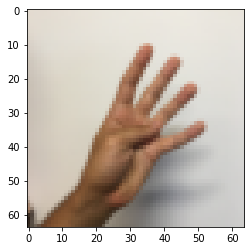

In [7]:
# Examplo de uma imagemo
index = 35
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

### 2.2 - Processamento dos dados

Para os dados poderem ser usados para o desenvolvimento da RNA devemos primeiramente processá-los.

Para isso devemos realizar as seguintes etapas:

- Dividir os dados de treinamento nos conjuntos de treinamento e validação;
- Os valores dos pixels em uma imagem é um número inteiro que deve ser transformado em número real para ser usado em cálculos;
- Normalizar as imagens de forma que os valores dos pixels fique entre 0 e 1.

**Divisão do conjunto de dados de treinamento**

Execute a célula abaixo para para dividir o conjunto de dados de treinamento nos conjuntos de treinamento e validação e redimensionar as saídas para que o primeiro eixo seja o dos exemplos e o segundo eixo o das classes.

In [8]:
# Dados de entrada
X_train_int = X_train_orig[:960,:]
X_val_int = X_train_orig[960:,:]

# Dados de saída
Y_train = Y_train_orig[:,:960].T
Y_val = Y_train_orig[:,960:].T
Y_test = Y_test_orig.T

print("Dimensão do tensor de dados de entrada de treinamento =", X_train_int.shape)
print("Dimensão do tensor de dados de entrada de validação =", X_val_int.shape)
print("Dimensão do tensor de dados de saída de treinamento =", Y_train.shape)
print("Dimensão do tensor de dados de saída de validação =", Y_val.shape)
print("Dimensão do tensor de dados de saída de test =", Y_test.shape)

Dimensão do tensor de dados de entrada de treinamento = (960, 64, 64, 3)
Dimensão do tensor de dados de entrada de validação = (120, 64, 64, 3)
Dimensão do tensor de dados de saída de treinamento = (960, 1)
Dimensão do tensor de dados de saída de validação = (120, 1)
Dimensão do tensor de dados de saída de test = (120, 1)


**Normalização dos dados de entrada**

Execute a célula abaixo para normalizar e transformar as imagens em números reais dividindo por 255.

In [9]:
# Guarda dimensão das imagens
image_dim = X_train_int.shape[1:4]
print("Dimensão das imagens de entrada=", image_dim)

# Transformação dos dados em números reais
X_train = X_train_int.astype('float32') / 255
X_val = X_val_int.astype('float32')/255
X_test = X_test_orig.astype('float32') / 255

# Para verificar se os resultados estão corretos
print("Primeiros elementos da primeira linha da primeira imagem de treinamento = ", X_train[0,0,0:4,1])
print("Primeiros elementos da primeira linha da primeira imagem de validação = ", X_val[0,0,0:4,1])
print("Primeiros elementos da primeira linha da primeira imagem de teste = ", X_test[0,0,0:4,1])

Dimensão das imagens de entrada= (64, 64, 3)
Primeiros elementos da primeira linha da primeira imagem de treinamento =  [0.8627451  0.8666667  0.87058824 0.8666667 ]
Primeiros elementos da primeira linha da primeira imagem de validação =  [0.85882354 0.85882354 0.85882354 0.85882354]
Primeiros elementos da primeira linha da primeira imagem de teste =  [0.8784314  0.8784314  0.88235295 0.88235295]


**Codificação das classes**

As classes dos sinais são identificadas por um número inteiro que varia de 0 a 5. Porém, a saída esperada de uma RNA para um problema de classificação de múltiplas classes é um vetor de dimensão igual ao número de classes, que no caso são 6 classes. Cada elemento desse vetor representa a probabilidade da imagem ser um sinal. Assim, devemos transformar as saídas reais do conjunto de dados em um vetor linha de 6 elementos, com todos os elementos iguais a zero a menos do correspondente ao da classe do sinal, que deve ser igual a um. A função que realiza essa transformação é conhecida na literatura de “one-hot-encoding”, que no Keras é chamada de "to_categorical". Execute a célula abaixo para transformar os dados de saída usando a função "to_categorical" do keras.


In [10]:
# Importa classe de utilidades do Keras
from tensorflow.keras.utils import to_categorical

# Transformação das classes de números reais para vetores
Y_train_hot = to_categorical(Y_train) 
Y_val_hot = to_categorical(Y_val) 
Y_test_hot = to_categorical(Y_test)

print('Dimensão dos dados de saída do conjunto de treinamento: ', Y_train_hot.shape)
print('Dimensão dos dados de saída do conjunto de validação: ', Y_val_hot.shape)
print('Dimensão dos dados de saída do conjunto de teste: ', Y_test_hot.shape)

Dimensão dos dados de saída do conjunto de treinamento:  (960, 6)
Dimensão dos dados de saída do conjunto de validação:  (120, 6)
Dimensão dos dados de saída do conjunto de teste:  (120, 6)


**Visualização da entrada e saída correspondente**

Execute a célula abaixo para verificar se o programa realizou de fato o que era esperado. No código abaixo index é o número sequencial da imagem. Tente trocar a imagem, mudando o index, usando valores entre 0 e 959, para visualizar outros exemplos.

Classe numérica:  [5] , Vetor de saída correspondentes:  [0. 0. 0. 0. 0. 1.]


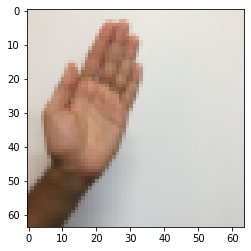

In [11]:
# Exemplo de saída
index = 13
print("Classe numérica: ", Y_train[index], ", Vetor de saída correspondentes: ", Y_train_hot[index])
plt.imshow(X_train_orig[index], cmap='gray', vmin=0, vmax=255)

## 3 - RNA convolucional

Nesse trabalho você irá usar uma RNA convolucional e, assim, poderá verificar que uma RNA convolucional é mais eficiente para processar imagens do que uma RNA com camadas somente densas, como foi feito no Trabalho #5.

### Exercício #1: criação da RNA

Você vai usar uma RNA com 3 camadas convolucionais, seguidas de camadas "max-pooling", e 3 camadas densas, com as seguintes características:

- Primeira camada convolucional: número de filtros n1, dimensão do filtro 3, "padding valid", "stride" 1, função de ativação ReLu;
- Segunda camada convolucional: número de filtros n2, dimensão do filtro 3, "padding valid", "stride" 1, função de ativação ReLu;
- Terceira camada convolucional: número de filtros n3, dimensão do filtro 3, "padding valid", "stride" 1, função de ativação ReLu;
- Camadas de max-pooling: dimensão da janela 2, "stride" 2; 
- Primeira camada densa: número de neurônios n4, função de ativação ReLu;
- Segunda camada densa: número de neurônios n5, função de ativação ReLu;
- Camada de saída: número de neurônio n6, função de ativação softmax.

Ressalta-se que após cada camada convolucional tem uma camada de max-pooling.

Na célula abaixo crie uma função que recebe a dimensão dos dados de entrada e os números de neurônios das camadas e configura a RNA de acordo com as características acima. Não se esqueça de incluir a camada de "flattening" entre a última camada de max-pooling e a primeira camada densa.

In [0]:
# PARA VOCÊ FAZER: Função para configuração da RNA

# Importa classes do Keras de modelos e camadas
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(data_shape, n1, n2, n3, n4, n5, n6):
    """
    Essa função configura uma rede neural deep-learnig
    
    Argumentos:
    data_shape = tuple com dimensões dos dados de entrada da rede
    n1 = número de neurônios da primeira camada
    n2 = número de neurônios da segunda camada
    n3 = número de neurônios da camada de saída
       
    Retorna: modelo da rede neural
    """
    model = models.Sequential()
    
    # Adicione as camadas em seu modelo de RNA
    #### COMECE AQUI ### (≈ 10 linhas)
    model.add( layers.Conv2D( n1, (3,3), padding='valid', strides=1, activation='relu', input_shape=data_shape ) )
    model.add( layers.MaxPooling2D( (2, 2) ) )
    model.add( layers.Conv2D( n2, (3,3), padding='valid', strides=1, activation='relu' ) )
    model.add( layers.MaxPooling2D( (2, 2) ) )
    model.add( layers.Conv2D( n3, (3,3), padding='valid', strides=1, activation='relu' ) )
    model.add( layers.MaxPooling2D( (2, 2) ) )
    model.add( layers.Flatten() )
    model.add( layers.Dense( n4, activation='relu' ) )
    model.add( layers.Dense( n5, activation='relu' ) )
    model.add( layers.Dense( n6, activation='softmax' ) )
    ### TERMINE AQUI ###
    
    return model

Defina os números de neurônios das camadas convolucionais, das camadas densas e da camada de saída e crie a RNA usando a função `build_model` criada na célula anterior. Utilize n1 = 8, n2 = 16, n3 = 32, n4 = 64, n5 = 32, n6 = 6. Após criar a RNA utilize o método summary para visualizar a sua rede.

In [21]:
# PARA VOCÊ FAZER: criação da RNA

# Inicializa o gerador de números aleatórios
np.random.seed(13)

# Dimensão dos dados de entrada
#### COMECE AQUI ### (≈ 1 linha) 
data_shape = image_dim
### TERMINE AQUI ###

# Definição dos números de neurônios das camadas
#### COMECE AQUI ### (≈ 6 linhas)
n1 = 8
n2 = 16
n3 = 32
n4 = 64
n5 = 32
n6 = 6
### TERMINE AQUI ###

# Cria rede neural deep learning e apresenta sua configuração
#### COMECE AQUI ### (≈ 2 linhas)
rna = build_model( data_shape, n1, n2, n3, n4, n5, n6 )
rna.summary()
### TERMINE AQUI ###


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

**Saída esperada:**

    Model: "sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    conv2d (Conv2D)              (None, 62, 62, 8)         224       
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 31, 31, 8)         0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 29, 29, 16)        1168      
    _________________________________________________________________
    max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
    _________________________________________________________________
    conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
    _________________________________________________________________
    max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
    _________________________________________________________________
    flatten (Flatten)            (None, 1152)              0         
    _________________________________________________________________
    dense (Dense)                (None, 64)                73792     
    _________________________________________________________________
    dense_1 (Dense)              (None, 32)                2080      
    _________________________________________________________________
    dense_2 (Dense)              (None, 6)                 198       
    =================================================================
    Total params: 82,102
    Trainable params: 82,102
    Non-trainable params: 0
    _________________________________________________________________

### Exercício #2: Número de parâmetros da RNA

Calcule o número de parâmetros da sua RNA. Escreva as contas realizadas e os seus resultados a seguir:

- Número de parâmetros da camada convulucional 1 = 224
- Número de parâmetros da camada convulucional 2 = 1.168
- Número de parâmetros da camada convulucional 3 = 4.640
- Número de parâmetros da camada densa 1 = 73.792
- Número de parâmetros da camada densa 2 = 2.080
- Número de parâmetros da camada de saída = 198


### Exercício #3: Compilação e treinamento da RNA

Agora você vai treinar a sua RNA usando o método de otimização Adams. Assim, na célula abaixo, compile e treine a sua RNA usando os seguinte hiperparâmetros:

- método Adam;
- taxa de aprendizagem = 0.001;
- beta1 = 0.9;
- beta2 = 0.999;
- decay = 0;
- número de épocas = 40.

In [22]:
# PARA VOCÊ FAZER: compilação e treinamento da RNA usando o método do gradiente descendente com momento

# importa do keras a classe dos otimizadores
from tensorflow.keras import optimizers

# Configuração do otimizador
### COMECE AQUI ### (≈ 2 linhas)
adam = optimizers.Adam( lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0 )
rna.compile( optimizer=adam, loss='categorical_crossentropy', metrics=['acc'] )
### TERMINE AQUI ###

# Treinamento da RNA
### COMECE AQUI ### (≈ 1 linha)
history = rna.fit( X_train, Y_train_hot, epochs=40, validation_data=( X_val, Y_val_hot ), verbose=1 )
### TERMINE AQUI ###

Epoch 1/40
30/30 [==============================] - 2s 74ms/step - loss: 1.7948 - acc: 0.1896 - val_loss: 1.7791 - val_acc: 0.2000
Epoch 2/40
30/30 [==============================] - 2s 69ms/step - loss: 1.7481 - acc: 0.2750 - val_loss: 1.7055 - val_acc: 0.3417
Epoch 3/40
30/30 [==============================] - 2s 69ms/step - loss: 1.4564 - acc: 0.4896 - val_loss: 1.2907 - val_acc: 0.4833
Epoch 4/40
30/30 [==============================] - 2s 69ms/step - loss: 1.0939 - acc: 0.5719 - val_loss: 1.0949 - val_acc: 0.5667
Epoch 5/40
30/30 [==============================] - 2s 69ms/step - loss: 0.8768 - acc: 0.6729 - val_loss: 0.8810 - val_acc: 0.6083
Epoch 6/40
30/30 [==============================] - 2s 71ms/step - loss: 0.7434 - acc: 0.7354 - val_loss: 0.7630 - val_acc: 0.6833
Epoch 7/40
30/30 [==============================] - 2s 70ms/step - loss: 0.5849 - acc: 0.8062 - val_loss: 0.6022 - val_acc: 0.7750
Epoch 8/40
30/30 [==============================] - 2s 70ms/step - loss: 0.4840 - a

**Saída esperada:**

    Train on 960 samples, validate on 120 samples
    Epoch 1/40
    960/960 [==============================] - 2s 2ms/sample - loss: 1.7913 - acc: 0.1594 - val_loss: 1.7828 - val_acc: 0.2833
    .
    .
    .
    Epoch 40/40
    960/960 [==============================] - 0s 479us/sample - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2762 - val_acc: 0.9250

### Visualização dos resultados

Execute a célula a seguir para fazer os gráficos da função de custo e da métrica para os dados de treinamento e validação.

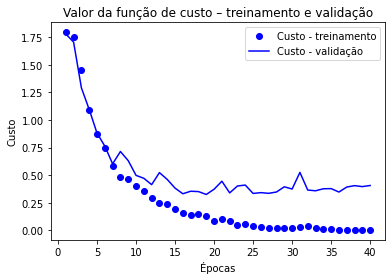

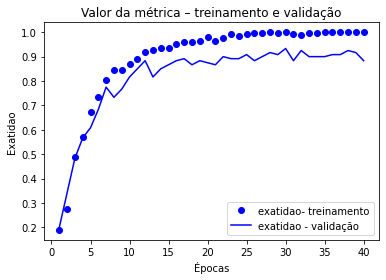

In [24]:
# Salva treinamento na variável history para visualização
history_dict = history.history

# Salva custos, métricas e epocas em vetores 
custo = history_dict['loss']
acc = history_dict['acc']
val_custo = history_dict['val_loss']
val_acc = history_dict['val_acc']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'bo', label='Custo - treinamento')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, acc, 'bo', label='exatidao- treinamento')
plt.plot(epocas, val_acc, 'b', label='exatidao - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

### Análise dos resultados

Pelos gráficos da função de custo e da métrica você deve observar o seguinte:

- O treinamento é bem rápido, sendo que em somente 40 épocas obtém-se uma extaidão de 100% para os dados de treinamento.
- O valor do custo para os dados de treinamento diminui constantemente ao longo do treinamento e a exatidão aumenta constantemente.
- O valor do custo para os dados de validação diminuem até a época 20 e depois estabiliza.
- A exatidão para os dados de validação aumenta constantemente ao longo do treinamento, mas menos do que para os dados de treinamento.
- A exatidão obtida para os dados de validação é de cerca de 92,5%, o que pode ser considerado um resultado muito bom.

### Exercício #4: Avaliação do desempenho da RNA

Na célula abaixo, usando o método `evaluate`, verifique o desempenho da RNA calculando o valor do custo e da métrica para os dados de treinamento, validação e teste.

In [25]:
# PARA VOCÊ FAZER: cálculo do custo e exatidão para os dados de treinamento, validação e teste

### COMECE AQUI ### (≈ 3 linhas)
custo_e_metricas_train = rna.evaluate( X_train, Y_train_hot, batch_size=1, verbose=1 )
custo_e_metricas_val = rna.evaluate( X_val, Y_val_hot, batch_size=1, verbose=1 )
custo_e_metricas_test = rna.evaluate( X_test, Y_test_hot, batch_size=1, verbose=1 )
### TERMINE AQUI ###

print(custo_e_metricas_train)
print(custo_e_metricas_val)
print(custo_e_metricas_test)

120/120 [==============================] - 0s 2ms/step - loss: 0.2257 - acc: 0.9417
[0.0037753144279122353, 1.0]
[0.4166781008243561, 0.8833333253860474]
[0.22573232650756836, 0.9416666626930237]


**Saída esperada:**

    960/960 [==============================] - 0s 215us/sample - loss: 0.0022 - acc: 1.0000
    120/120 [==============================] - 0s 241us/sample - loss: 0.2762 - acc: 0.9250
    120/120 [==============================] - 0s 249us/sample - loss: 0.2151 - acc: 0.9417
    [0.0021954899944830685, 1.0]
    [0.2761955052614212, 0.925]
    [0.2150653511285782, 0.94166666]

### Exercício #5: Verificação dos resultados

Na célula abaixo calcule a previsões da sua RNA para as imagens do conjunto de teste e depois verifique se algumas dessas previsões estão corretas. 

Note que a previsão da RNA é um vetor de 6 elementos com as probabilidades da imagem mostrar os seis sinais. Para detereminar a classe prevista deve-se transformar esse vetor em um número inteiro de 0 a 5, que representa o sinal sendo mostrado. Para fazer essa transformação use a função numpy `argmax(Y_test, axis=?)`, onde `Y_test` é o tensor com as saídas previstas pela RNA. Em qual eixo você deve calcular o índice da maior probabilidade?

Troque a variável index (variando entre 0 e 119) para verificar se a sua RNA consegue classificar corretamente o sinal de mão mostrado nas imagens.

y = 0


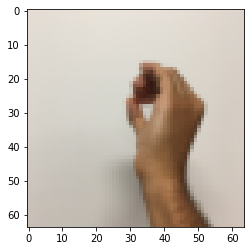

In [29]:
# PARA VOCÊ FAZER: cálculo das classes previstas 

# Calculo das previsões da RNA
### COMECE AQUI ### (≈ 1 linha)
Y_test = np.argmax(Y_test_hot, axis=1)
### TERMINE AQUI ###

# Cálculo das classes previstas
### COMECE AQUI ### (≈ 1 linha)
classe = np.argmax(rna.predict(X_test), axis=1)
### TERMINE AQUI ###

# Exemplo de uma imagem dos dados de teste
index = 18
plt.imshow(X_test_orig[index])
print ("y = " + str(np.squeeze(classe[index])))

### Exercício #6: Visualização dos resultados

Na célula abaixo crie um código para fazer um gráfico com as classes reais e as previstas pela sua RNA para todos os exemplos do connjunto de teste.

Dimensão vetor classes reais=  (1, 120)
Dimensão vetor classes previstas=  (120,)


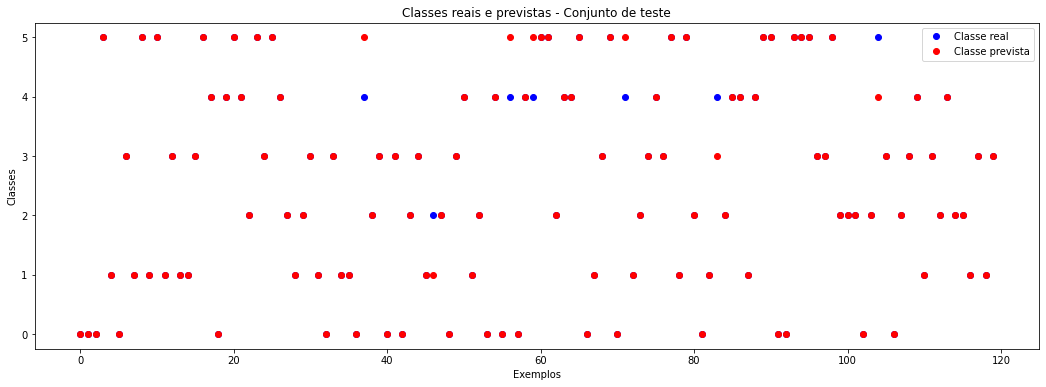

In [30]:
# PARA VOCÊ FAZER: visualização das classes previstas pela RNA de todas as imagens do conjunto de teste

# Resultado gráfico
# Verifique dimensoes dos vetores de classes reais e previstas
print('Dimensão vetor classes reais= ', Y_test_orig.shape)
print('Dimensão vetor classes previstas= ', classe.shape)

# Fazer o gráfico das classes reais e previstas
plt.figure(figsize=(18, 6))
### COMECE AQUI ### (≈ 7 linhas)
plt.plot(Y_test, 'bo', label='Classe real')
plt.plot(classe, 'ro', label='Classe prevista')
plt.title('Classes reais e previstas - Conjunto de teste')
plt.xlabel('Exemplos')
plt.ylabel('Classes')
plt.legend()
plt.show()
### TERMINE AQUI ###


**Saída prevista:**

    Dimensão vetor classes reais=  (1, 120)
    Dimensão vetor classes previstas=  (120,)

<img src="classes_reais_previstas.png">

### Exercício #7: Criação do modelo para visualização das saídas das camadas convolucionais

Para visualizar as saídas das camadas de uma RNA deve-se criar um modelo que recebe uma imagem como entrada e gera como saída as ativações das camadas que se deseja visualizar. O Keras possui a classe de modelos "Keras Class Model"para fazer isso. 

Na célula abaixo crie esse modelo usando dois argumentos: (1) tensores de entrada; (2) lista de tensores de saída, que são as saídas das 6 primeiras camadas da sua RNA (3 camadas convolucionais e 3 camadas max-pooling). 

In [32]:
# PARA VOCÊ FAZER: criação do modelo para visualização das saídas das camadas convolucionais

# importa classe de modelos do keras
from tensorflow.keras import models

# Define as saídas como sendo as ativações das seis primeiras camadas da RNA
### COMECE AQUI ### (≈ 1 linha)
layer_outputs = [layer.output for layer in rna.layers[:6]]
### TERMINE AQUI ###

# Cria e mostra a configuração do modelo que retorna as ativações das camadas, dada uma entrada
### COMECE AQUI ### (≈ 2 linha)
activation_model = models.Model( inputs=rna.input, outputs=layer_outputs )
activation_model.summary()
### TERMINE AQUI ###


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7_input (InputLayer)  [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0     

**Saída esperada:**

    Model: "model"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    conv2d_input (InputLayer)    [(None, 64, 64, 3)]       0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 62, 62, 8)         224       
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 31, 31, 8)         0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 29, 29, 16)        1168      
    _________________________________________________________________
    max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
    _________________________________________________________________
    conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
    _________________________________________________________________
    max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
    =================================================================
    Total params: 6,032
    Trainable params: 6,032
    Non-trainable params: 0
    _________________________________________________________________

### Exercício #8: Redimensionamento da imagem para visualização das saídas 

Quando esse modelo recebe uma imagem de entrada, ele retorna as ativações das camadas da RNA original escolhidas com saídas. No caso dessa RNA temos uma entrada e seis saídas, uma saída para cada conjunto de ativações das camadas convolucionais e max-pooling.

A imagem usada como entrada dessa nova rna deve ser um tensor de mesmo tamanho que o usado na RNA original. Uma imagem colorida tem 3 eixos (altura, largura, cor) e o tensor de entrada da RNA tem 4 eixos (exemplo, altura, largura, cor), portanto, deve-se incluir um quarto eixo na imagem antes dela ser usada como entrada desse modelo.

Na célula abaixo crie um código que inclui esse novo eixo em uma imagem colorida.

Dimensão do tensor criado com a imagem escolhida =  (1, 64, 64, 3)


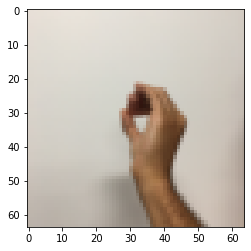

In [61]:
# PARA VOCÊ FAZER: inclusão do eixo de exemplo em uma imagem

# Escolhe imagem do conjunto de teste e transforma em um tensor com mesmo numero de eixos do tensor de entrada da RNA
index = 1

# Imagem colorida tem 3 eixos (altura, largura, cor), tensor de entrada da RNA tem 4 eixos (exemplo, altura, largura, cor)
### COMECE AQUI ### (≈ 1 linha)
#imagem = np.reshape( X_test_orig[index], (1,) + X_test_orig[index].shape )
imagem = np.expand_dims( X_test_orig[index], axis=0 )
### TERMINE AQUI ###

print("Dimensão do tensor criado com a imagem escolhida = ", imagem.shape)

# Apresenta imagem
plt.imshow(imagem[0])
plt.show()

**Saída esperada:**

    Dimensão do tensor criado com a imagem escolhida =  (1, 64, 64, 3)

### Exercício #9: Execução da nova RNA 

O próximo passo para visualização das saídas das camadas convolucionais é executar o novo modelo em modo de predição. Crie na célula abaixo um código para obter a saída da primeira camada convolucional.

In [62]:
# PARA VOCÊ FAZER: cálculo das saídas das camadas convolucionais

# calcula saídas das camadas convolucionais usando a RNA activation_model com o método predict
### COMECE AQUI ### (≈ 2 linhas)
activations = activation_model.predict( imagem )
first_layer_activation = activations[0]
### TERMINE AQUI ###

print("Dimensão do tensor de saída da primeira camada convolucional =", first_layer_activation.shape)

Dimensão do tensor de saída da primeira camada convolucional = (1, 62, 62, 8)


**Saída esperada:**

    Dimensão do tensor de saída da primeira camada convolucional = (1, 62, 62, 8)

Observe que a saída dessa primeira camada convolucional é um mapa de características de dimensão 62x62 com 8 canais. Execute a célula abaixo para visualizar as saídas dos filtros dessa camada. Troque a variável index (use um valor entre 0 e 7) para visualizar os 8 canais.


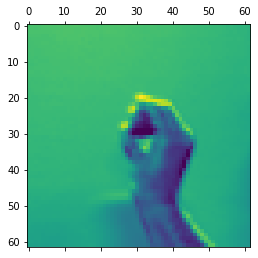

In [65]:
index = 0
plt.matshow(first_layer_activation[0,:,:,index], cmap='viridis')

Execute a célula abaixo para visulizar as saídas de todos os filtros de todas as camadas convolucionais e max-polling para essa imagem de entrada.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


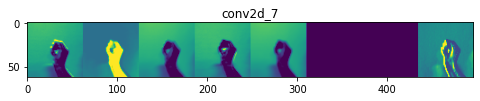

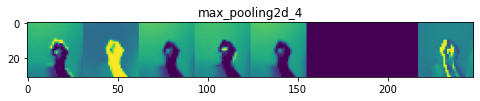

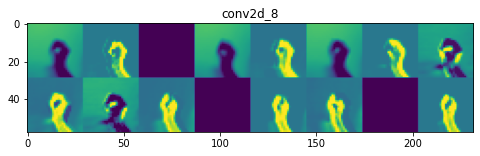

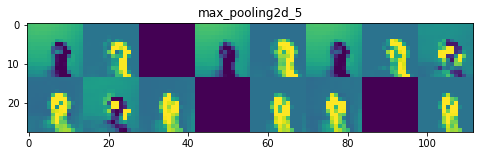

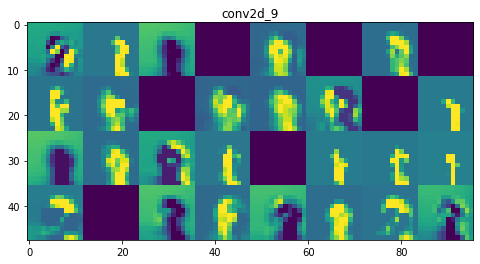

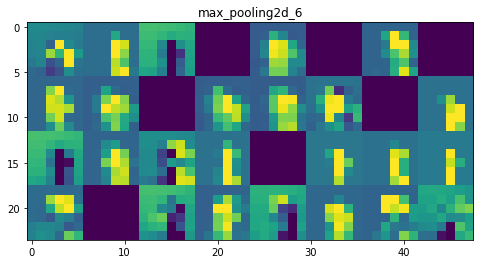

In [66]:
# Visualização de todos os canais das saídas das camadas convolucionais selecionadas
layer_names = []

for layer in rna.layers[:6]:
    layer_names.append(layer.name)

images_per_row = 8

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Conclusões

A partir desses resultados você pode concluir o seguinte:

- Em geral as primeiras camadas de uma RNA convolucional agem como uma coleção de detectores de vários tipos de bordas.
- Nas primeiras camadas a ativações contém quase toda a informação presente na imagem original.
- Na medida em que avançamos para dentro da rede, as ativações se tornam mais abstratas e com menor significado visual e começam a codificar características de alto nível.
- Características de níveis mais alto contém menos informação visual e mais informações relacionadas com a tarefa a ser realizada.
- A não ativação de filtros para uma determindada imagem aumenta com a profundidade da camada: na 1ª camada praticamente todos os filtros são ativados, mas nas camadas mais profundas menos filtros ficam ativos.
- Quando um filtro não é ativado por uma imagem, significa que o padrão codificado por aquele filtro não está presente naquela imagem.
- Uma característica importante das RNAs convolucionais deep learning é que as características aprendidas pelas suas camadas se tornam cada vez mais abstratas com a profundidade da camada. 
- Uma RNA deep learning age efetivamente como um destilador de informação, onde dados brutos são repetidamente transformados de forma que informações irrelevantes são descartadas e informações importantes são ressaltadas e refinadas.

**Importante:** 

- Observe que essa RNA possui 82.102 parâmetros, enquanto que a RNA densa usada no Trabalho #5 para fazer essa mesma tarefa possuia 788.774 parâmetros.
- Mesmo com um número muito menor de parâmetros a RNA convolucional é capaz de obter resultados melhores do uma RNA densa.
